In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
%matplotlib inline

In [2]:
# Load data
data = np.loadtxt('cluster.dat')

Ks = [2,3,4,5,6,7,8]
tmax = 15 # 5

In [3]:
def make_prototypes(data, K):
    # Initialization of prototypes
    data_mean = np.mean(data, axis=1)
    x_dist = np.max(data[0]) - np.min(data[0])
    y_dist = np.max(data[1]) - np.min(data[1])
        
    prototypes = (np.random.rand(2,K) - 0.5)  * np.array([x_dist, y_dist])[:,np.newaxis]
    return prototypes

In [4]:
data.shape

(2, 500)

In [37]:
def plot_clusters(data, ps):
    plt.figure()
    plt.scatter(data[0], data[1], c='grey', alpha=0.5)
    plt.scatter(ps[0], ps[1], c="red")
    plt.show()
    
def plot_clusters_with_original(data, ps, ps_original):
    plt.figure()
    plt.scatter(data[0], data[1], c='grey', alpha=0.5)
    plt.scatter(ps[0], ps[1], c="red")
    plt.scatter(ps_original[0], ps_original[1], c="red", marker="x")
    plt.show()
    
def kmeans_error(data, ps):
    dists = cdist(data.T, ps.T).T
    return np.sum(np.min(dists, axis=0)) / (2 * data.shape[1])

In [6]:
def kmeans(data, K, tmax, plot=True):
    ps = make_prototypes(data, K)
    if plot:
        plot_clusters(data, ps)
    
    errors = []
    for t in range(tmax):
        dists = cdist(data.T, ps.T).T
        cluster = np.argmin(dists, axis=0)

        for q in range(K):
            ps[:,q] = np.mean(data[:, cluster == q], axis=1)
        if plot:
            plot_clusters(data, ps)
        errors.append(kmeans_error(data, ps))
    if plot:
        plt.plot(range(tmax), errors)
    else:
        return errors

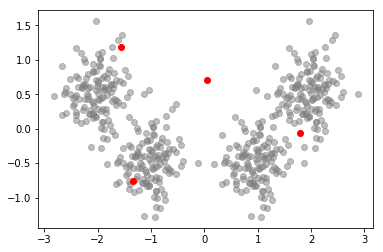

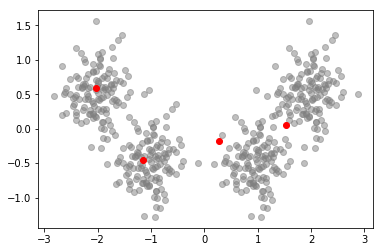

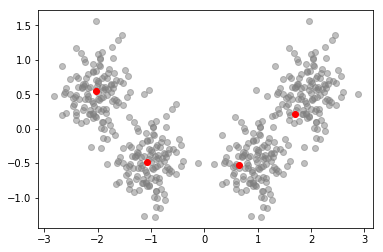

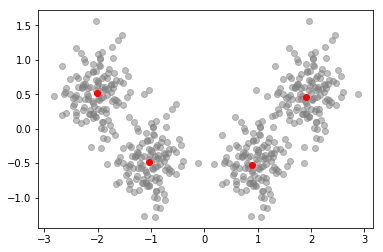

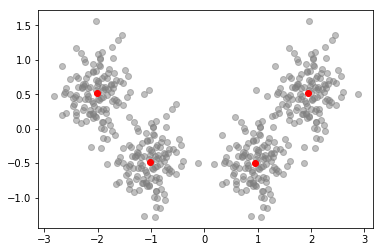

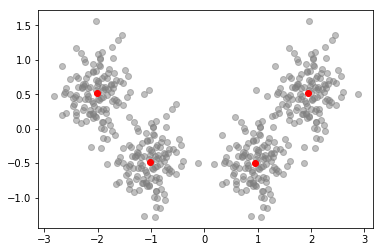

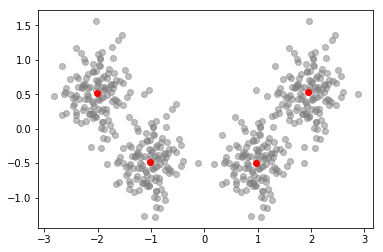

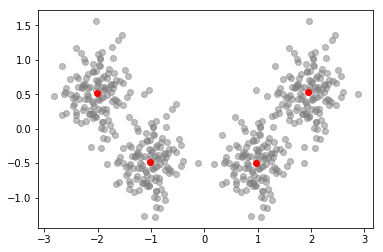

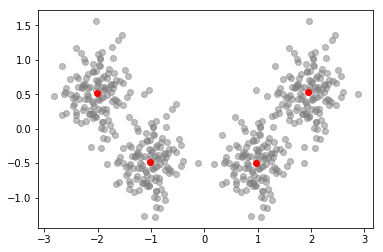

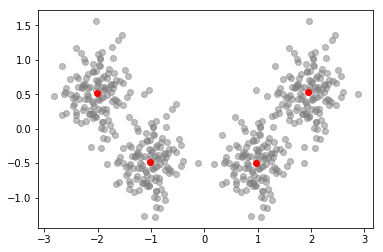

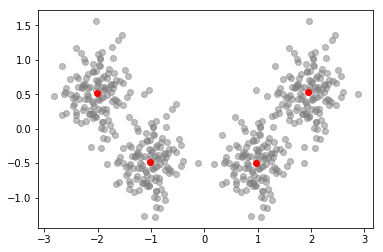

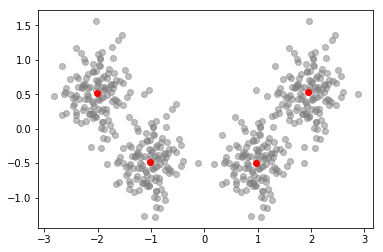

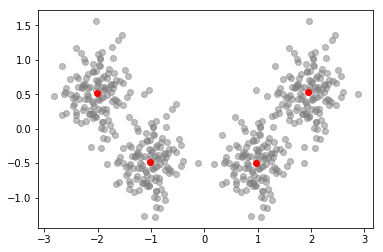

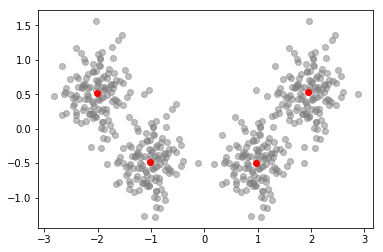

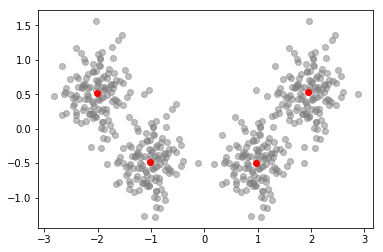

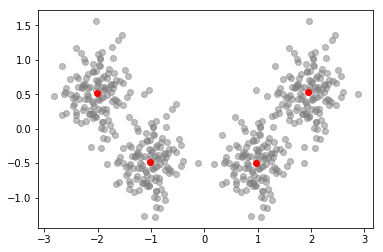

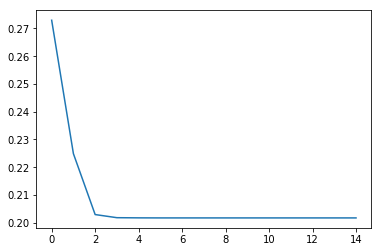

In [24]:
kmeans(data, Ks[2], tmax)

## 9.2

In [8]:
def online_kmeans(data, K, tau=0.99, tmax=None, plot=True):
    ps = make_prototypes(data, K)
    
    eps = 0.2

    if not tmax:
        tmax = data.shape[1]
    
    centroids = np.zeros((2, K, tmax))
    errors = []
    for t in range(tmax):
        if plot and t % 100 == 0:
            plot_clusters(data, ps)
        centroids[:, :, t] = ps
        
        i = np.random.choice(data.shape[1])
        
        dists = cdist(data[:,i:i+1].T, ps.T).T

        q = np.argmin(dists, axis=0)

        if t > tmax/4:
            eps = tau * eps

        ps[:,q] += eps * (data[:,i:i+1] - ps[:, q])
        
        errors.append(kmeans_error(data, ps))
    
    if plot:
        plt.plot(range(tmax), errors)
    return centroids

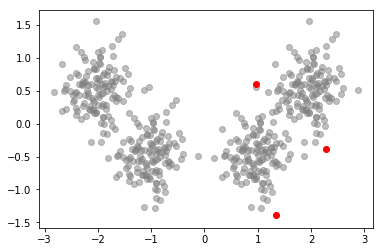

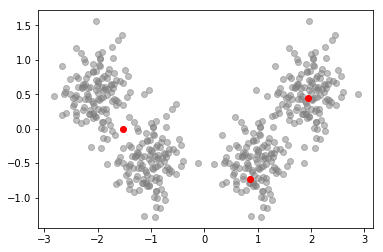

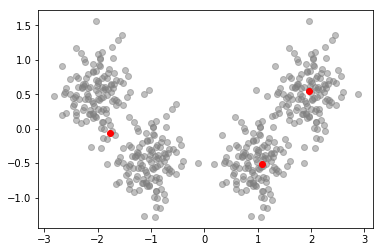

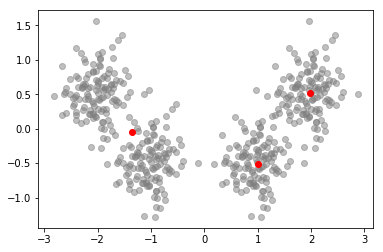

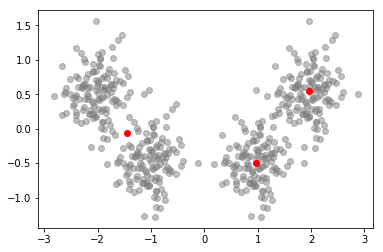

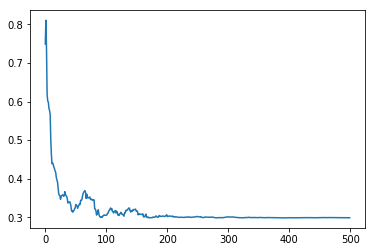

In [9]:
centroids = online_kmeans(data, 3)

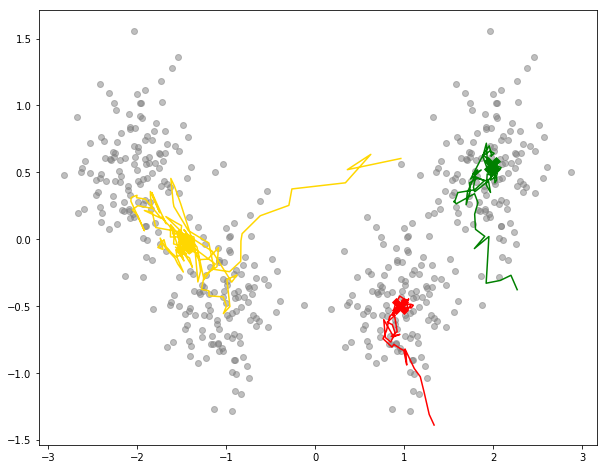

In [10]:
colors = ['green', 'red', 'gold', 'black']

plt.figure(figsize=(10,8))
plt.scatter(data[0], data[1], c='grey', alpha=0.5)
for K in range(3):
    plt.scatter(centroids[0,K,-1], centroids[1,K,-1], c=colors[K], s=250, marker='X')
    plt.plot(centroids[0, K, :], centroids[1, K, :], c=colors[K])
plt.show()

## 9.3

In [38]:
def soft_kmeans(data, K, ps, beta, gamma):
    t = 0
    ps_old = np.copy(ps)
    ps_original = np.copy(ps)
    while True:
        
        M = np.zeros((data.shape[1], K))
        for alpha in range(data.shape[1]):
            for q in range(K):
                M[alpha, q] = np.exp(-0.5*beta * np.linalg.norm(data[:,alpha] - ps[:, q]))
        M = M / np.sum(M, axis=1)[:, np.newaxis]

        for q in range(K):
            ps[:, q] = np.sum(M[:, q] * data, axis=1) / np.sum(M[:, q])

        if np.max(np.abs(ps - ps_old)) < gamma:
            plot_clusters_with_original(data, ps, ps_original)
            print("Breaking at step: ", t)
            break
        else:
            #plot_clusters(data, ps)
            ps_old = np.copy(ps)
            t += 1
    return M

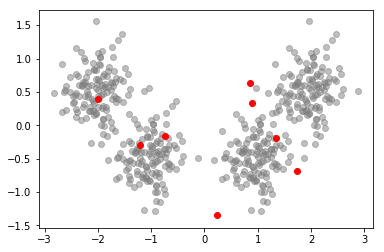

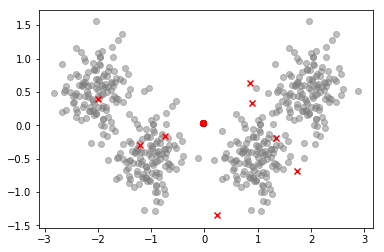

Breaking at step:  3
0.125061332812
[ 0.12504134  0.12503118  0.12504116  0.12504877  0.12503844  0.12505864
  0.12504135  0.12505996  0.12505949  0.12503404  0.12504918  0.12503766
  0.12504057  0.12506133  0.12503979  0.12504361  0.12504109  0.12505555
  0.12503008  0.12503654  0.1250613   0.1250385   0.12505734  0.12505462
  0.12505703  0.12505288  0.12504128  0.12505998  0.12504137  0.12506128
  0.12504125  0.12505526  0.12505808  0.12505894  0.12505818  0.1250386
  0.12505617  0.12506021  0.12506004  0.12501059  0.12504087  0.12504984
  0.12504033  0.1250543   0.12503898  0.12504099  0.12503569  0.1250611
  0.12505825  0.12505818  0.12505239  0.12504652  0.12506034  0.12506048
  0.12505813  0.12505874  0.12505973  0.1250572   0.12504118  0.12505751
  0.12505776  0.12506108  0.12505152  0.12504026  0.12505945  0.12506019
  0.12506035  0.12504136  0.12505202  0.12505664  0.12504085  0.12505863
  0.12504552  0.12503651  0.1250412   0.12505503  0.12506078  0.12504111
  0.12504823  0.1

ValueError: operands could not be broadcast together with shapes (500,8) (500,) 

In [39]:
# a)
K = 8
ps = make_prototypes(data, K)
gamma = 0.01

# b)
betas = np.linspace(0.2, 20, 10) # 100
plot_clusters(data, ps)

for beta in betas:
    M = soft_kmeans(data, K, ps, beta, gamma)
    
    
    rgba_colors = np.zeros((data.shape[1], 4))
    # for red the first column needs to be one
    rgba_colors[:,1] = 1.0
    # the fourth column needs to be your alphas
    print(np.max(M))
    print(np.max(M, axis=1))
    rgba_colors[:, 3] = M/np.max(M, axis=1)

    plt.scatter(data[0,:], data[1:], color=rgba_colors)